In [1]:

import matplotlib.pyplot as plt
from jupyterthemes import jtplot
jtplot.style(context='talk', fscale=1.4, spines=False, gridlines='--')

import dos


In [2]:

simulation_path = './dos/FEMSimuLink'
sim = dos.DOS(simulation_path, show_timing = 2)


INFO:DOS:Reading config from ./dos/FEMSimuLink/dos.yaml
INFO:DOS:New driver: wind_loads
INFO:wind_loads:New output: Gravity
INFO:wind_loads:New output: Distributed
INFO:wind_loads:New output: TopEnd
INFO:wind_loads:New output: Truss
INFO:wind_loads:New output: GIR
INFO:wind_loads:New output: CRING
INFO:wind_loads:New output: M1
INFO:wind_loads:New output: M1Cell
INFO:wind_loads:New output: M2
INFO:wind_loads:New output: M2Cell
INFO:DOS:New driver: FEM
INFO:FEM:New input: OSS_Grav_CS0
INFO:FEM:New input: OSS_AzDrive_F
INFO:FEM:New input: OSS_ElDrive_F
INFO:FEM:New input: OSS_GIRDrive_F
INFO:FEM:New input: OSS_M1_lcl_6F
INFO:FEM:New input: OSS_Cell_lcl_6F
INFO:FEM:New input: OSS_CRING_6F
INFO:FEM:New input: OSS_TopEnd_6F
INFO:FEM:New input: OSS_GIR_6F
INFO:FEM:New input: OSS_Truss_6F
INFO:FEM:New input: MC_M2_lcl_force_6F
INFO:FEM:New input: MC_M2_MacroCell_F_6d
INFO:FEM:New input: MC_M2_PZT_S1_F
INFO:FEM:New input: MC_M2_PZT_S2_F
INFO:FEM:New input: MC_M2_PZT_S3_F
INFO:FEM:New input: MC

In [3]:

sim.start()


INFO:DOS:Pushing configuration to server


In [6]:

sim.pctComplete


100

### Read and plot LOS data

---


In [5]:
import pickle
import numpy as np
import scipy.io as sio

file_path = "../CUDAIMS-NSEE/datafiles/CUDAIMSsysDt/memorymaps/dgnf.dat"
dgnf_mm = np.memmap(file_path, dtype=np.float32, mode='r+', shape=(21,84))
dgnf = dgnf_mm.view(dtype = np.float32, type = np.ndarray)

OSS_M1_LOS = sim.logs.entries['FEM']['OSS_M1_LOS'].timeSeries[1].T
MC_M2_LOS_6D = sim.logs.entries['FEM']['MC_M2_LOS_6D'].timeSeries[1].T

dec = 10
dt  = OSS_M1_LOS.shape[1]
nt  = dt // dec

LOS_outs = np.memmap('./LOS.dat', dtype=np.float32, mode='w+', shape=(21,dt))
for k in range(dec):
    ki, kii = nt * k, nt * (k + 1)
    if kii < dt:
        outs = np.concatenate((OSS_M1_LOS[:,ki:kii], MC_M2_LOS_6D[:,ki:kii]), axis=0)
    else:
        outs = np.concatenate((OSS_M1_LOS[:,ki:], MC_M2_LOS_6D[:,ki:]), axis=0)
    los  = dgnf @ outs 
    LOS_outs[:,ki:kii] = los[:,:]
    
LOS_sim = sio.loadmat('./LOS.mat')['outs']

In [6]:
index = 5

signal = LOS_outs[index, :10000]
sim_signal = LOS_sim[index, :10000]

plt.figure(figsize = (26,18))
plt.plot(signal, lw = 3.0)
plt.plot(sim_signal, lw = 1.3)
plt.show()

### Plotting simulation logs

---

Specifically plot the bending modes outputs


In [15]:
plt.figure(figsize = (16,8))
plt.plot(*sim.logs.entries['FEM']['Bending_modes'].timeSeries)
plt.show()

### Save a particular output in memory map

---

In [7]:
import numpy as np

signal_name   = 'bendingmodes_ST'
signal_values = sim.logs.entries['FEM']['Bending_modes'].timeSeries[1]

saved_mem_map = np.memmap('./'+signal_name+'.dat', dtype=np.float32, mode='w+', shape=signal_values.shape)
saved_mem_map[:,:] = signal_values[:,:]
del saved_mem_map

### Infomation analysis of the bending modes outputs

---



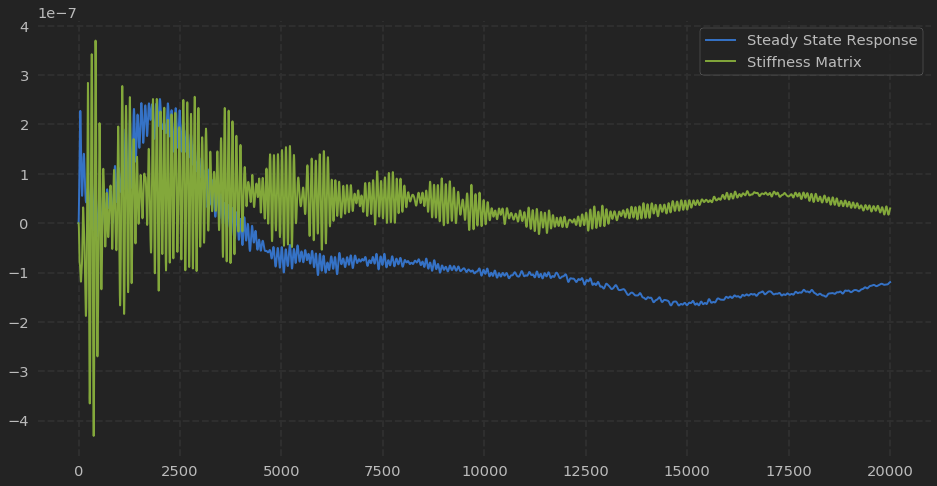

In [9]:

shape__ = (20000, 1144)
bm_ssr = np.memmap('./bendingmodes_SS.dat', dtype=np.float32, mode='r+', shape=shape__)
bm_stf = np.memmap('./bendingmodes_ST.dat', dtype=np.float32, mode='r+', shape=shape__)

index = 15

plt.figure(figsize=(16,8))
plt.plot(bm_ssr[:,index], '-', label='Steady State Response')
plt.plot(bm_stf[:,index], '--', label='Stiffness Matrix')
plt.legend()
plt.show()


### Terminate the simulation

---

In [17]:
sim.terminate

## Current Developments

---

### Read and compare two variables

In [19]:

shape__ = (20000, 1144)
bm_ssr = np.memmap('./bendingmodes_SS.dat', dtype=np.float32, mode='r+', shape=shape__)
bm_stf = np.memmap('./bendingmodes_ST.dat', dtype=np.float32, mode='r+', shape=shape__)

index = 150

plt.figure(figsize=(16,8))
plt.plot(bm_ssr[:,index], label='Steady State Response')
plt.plot(bm_stf[index,:], label='Stiffness')
plt.legend()
plt.show()
